In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from os.path import join
from tqdm import tqdm
from matplotlib.colors import LogNorm

import strawb
from strawb.tools import wavelength_to_rgb

import seaborn as sns


In [3]:
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../no_git/style.mplstyle")
colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]


# Setup

In [4]:
# load DB
db = strawb.SyncDBHandler(file_name="Default")  # loads the db


In [5]:
### these are the available device codes
print(db.dataframe.deviceCode.unique())

### different measurement types for PMTSPEC and LIDAR
print(db.dataframe.measurement_type.unique())


['ONCMJB016' 'TUMLIDAR001' 'TUMLIDAR002' 'TUMMINISPECTROMETER001'
 'TUMMUONTRACKER001' 'TUMPMTSPECTROMETER001' 'TUMPMTSPECTROMETER002'
 'TUMSTANDARDMODULE001' 'TUMSTANDARDMODULE004']
[nan 'counts' 'rate_scan' 'basic']


## select time range

In [6]:
mask = db.dataframe["deviceCode"] == "TUMPMTSPECTROMETER001"
mask &= db.dataframe["dataProductCode"] == "PMTSD"

timestamp = np.datetime64("2021-09-01T00:00:00")
mask &= db.dataframe.dateFrom >= pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC")
mask &= db.dataframe.dateFrom < pd.Timestamp(
    np.datetime64(timestamp, "h"), tz="UTC"
) + np.timedelta64(30, "D")


In [7]:
### see which files are synced
np.count_nonzero(db.dataframe[mask].synced), len(db.dataframe[mask])


(780, 780)

set up a column to track which files are known to be ok, or which files are known to be eg. corrupt

if not "file_ok" in db.dataframe:
    db.dataframe["file_ok"] = "None"

## download missing files

In [126]:
# check if files will be downloaded
if not db.dataframe.synced[mask].all():
    print("Files will be downloaded")
else:
    print("No files will be downloaded")


No files will be downloaded


In [9]:
### this will download the selected files
if not db.dataframe.synced[mask].all():
    db.update_db_and_load_files(
        db.dataframe[mask],
        output=True,  # print output to console
        download=True,  # download the files
        # save_db=True
    )
    db.save_db()


In [10]:
# mask by device
mask = db.dataframe["deviceCode"] == "TUMPMTSPECTROMETER001"
mask &= db.dataframe["dataProductCode"] == "PMTSD"

# and add mask by 'measurement_type'
mask &= db.dataframe.measurement_type.isnull() | (
    db.dataframe.measurement_type == "counts"
)
mask &= db.dataframe["synced"]


In [12]:
db.dataframe[mask]["file_ok"].head()


fullPath
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T000000.000Z-SDAQ-PMTSPEC.hdf5         ok
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T010000.000Z-SDAQ-PMTSPEC.hdf5         ok
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T020000.000Z-SDAQ-PMTSPEC.hdf5    corrupt
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030000.000Z-SDAQ-PMTSPEC.hdf5    corrupt
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030758.986Z-SDAQ-PMTSPEC.hdf5         ok
Name: file_ok, dtype: object

# Rate counting

## load or read data

In [16]:
identifier = "20210901"

In [8]:
good_trb_series = pd.read_pickle(
    f"/data/straw_b/processed_data/pmtspectrometer001/dataframes/{identifier}_good_trb_series.pickle"
)


In [26]:
meta[0]["index"]

3

In [27]:
good_trb_series = []
bins = np.arange(-1, 9, step=0.1)

# select file with the right data
mask = db.dataframe.deviceCode == "TUMPMTSPECTROMETER001"
mask &= db.dataframe.dataProductCode == "PMTSD"
mask &= db.dataframe.measurement_type.isnull() | (
    db.dataframe.measurement_type == "counts"
)
# only synced data
mask &= db.dataframe.synced
# load PMTSpec
for i, row in tqdm(db.dataframe[mask].iterrows()):
    # skip files that we know are bad
    if row.file_ok == "corrupt" or row.file_ok == "empty":
        continue
    try:
        # get the PMT data and its meta data (channel no. etc)
        pmt_specs_timeseries = strawb.sensors.PMTSpec(row.filename)
        meta = pmt_specs_timeseries.pmt_meta_data.channel_meta_array
        # select the channel with no wavelength filter
        filter_ind = meta[meta["wavelength"] == 0]["index"][0]
        selection = pmt_specs_timeseries.trb_rates.rate[filter_ind]
        ### as long as all this works, we don't expect any further file-reading errors
    except KeyError:
        # corrupt file
        print("Corrupt file:", row.filename)
        db.dataframe.loc[i, "file_ok"] = "corrupt"
        continue
    except OSError:
        # also corrupt file
        print("Corrupt file:", row.filename)
        db.dataframe.loc[i, "file_ok"] = "corrupt"
        continue
    except TypeError as e:
        # empty file
        print("Empty file:", row.filename)
        db.dataframe.loc[i, "file_ok"] = "empty"
        continue
    # loop over all wavelength channels
    for mm in meta:
        # select one wavelength channel
        selection = pmt_specs_timeseries.trb_rates.rate[mm["index"]]
        # aggregate multiple bins into something roughly representing 30 ms (=30 bins)
        stepsize = 30
        indx = np.arange(len(selection), step=stepsize)
        # weight the sum by the size of the time bins
        agg_rates = np.add.reduceat(
            selection * pmt_specs_timeseries.trb_rates.rate_delta_time, indx
        ) / np.add.reduceat(pmt_specs_timeseries.trb_rates.rate_delta_time, indx)
        agg_delta_time = np.add.reduceat(
            pmt_specs_timeseries.trb_rates.rate_delta_time, indx
        )

        # build a histogram of the rate series
        # mask rate counts with zero that mess up the log()
        mask = agg_rates > 0
        # check that the bin range is large enough
        assert bins[-1] > np.max(np.log10(agg_rates[mask]))
        assert bins[1] < np.min(np.log10(agg_rates[mask]))

        
        h, ed = np.histogram(np.log10(agg_rates[mask]), bins=bins)
        # ... and a histogram weighted with the size of the time intervals
        hw, _ = np.histogram(
            np.log10(agg_rates[mask]),
            bins=bins,
            weights=agg_delta_time[mask],
        )
        # we want to leave first bin as underflow for zero rate counts
        # -> check that the first bin for underflow is zero
        assert h[0] == 0
        assert hw[0] == 0

        # add zero counts as first "underflow" bin
        h[0] = np.count_nonzero(~mask)
        hw[0] = np.sum(agg_delta_time[~mask])
        good_trb_series.append(
            {
                "rate_hist": h,
                "weighted_rate_hist": hw,
                "rate_bins": bins,
                "zero_counts": h[0],  # total zero counts
                "weighted_zero_counts": hw[0],  # zero counts weighted with time interval
                "timestamp": pd.Timestamp(row.dateFrom),
                "filter": mm["wavelength"]
            }
        )
        db.dataframe.loc[i, "file_ok"] = "ok"
good_trb_series = pd.DataFrame(good_trb_series)
# save our marking of unreadable files, so we can skip them next time
db.save_db()
good_trb_series.to_pickle(
    f"/data/straw_b/processed_data/pmtspectrometer001/dataframes/{identifier}_good_trb_series.pickle"
)


100%|██████████| 12/12 [00:00<00:00, 33.98it/s]
750it [19:28,  1.56s/it]


In [28]:
db.dataframe[
    (db.dataframe.file_ok == "corrupt") | (db.dataframe.file_ok == "empty")
].fileSize


fullPath
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T020000.000Z-SDAQ-PMTSPEC.hdf5       46204
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210901T030000.000Z-SDAQ-PMTSPEC.hdf5       39994
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210912T020000.000Z-SDAQ-PMTSPEC.hdf5       46750
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210912T030000.000Z-SDAQ-PMTSPEC.hdf5       39999
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210921T020000.000Z-SDAQ-PMTSPEC.hdf5       45974
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210921T030000.000Z-SDAQ-PMTSPEC.hdf5       39994
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/TUMPMTSPECTROMETER001_20210926T020000.000Z-SDAQ-PMTSPEC.hdf5       46486
/data/straw_b/raw_module_data/tumpmtspectrometer001/2021_09/

## histogram helpers

In [29]:
def interpolate_quantile_value(
    q, xedges, yvals, offset=0, offset_type="underflow", verbose=False
):
    r"""Interpolate quantile values from a histogram.

    Parameters:
    -----------
    q: quantile, float between 0 and 1
    xedges: bin edges of the histogram with length n+1
    yvals: heights of the bins with length n
    offset: account for a low offset/underflow bin not in yvals
    offset_type: 'underflow', 'overflow'
    verbose: returns also the coordinates used for interpolation

    Returns:
    --------
    Quantile value based on interpolated histogram values,
    verbose=True: x and y coordinates of 2 points used for interpolation
    """
    cumulative_yvals = np.cumsum(yvals).astype(float)
    if offset_type == "underflow":
        cumulative_yvals += offset
        cumulative_yvals /= np.max(cumulative_yvals)
    elif offset_type == "overflow":
        cumulative_yvals /= offset

    mids = (xedges[:-1] + xedges[1:]) * 0.5
    mask_s = cumulative_yvals <= q
    mask_l = cumulative_yvals > q
    try:
        x1 = np.atleast_1d(mids[mask_s])[-1]
        x2 = np.atleast_1d(mids[mask_l])[0]
        y1 = np.atleast_1d(cumulative_yvals[mask_s])[-1]
        y2 = np.atleast_1d(cumulative_yvals[mask_l])[0]
    except:
        # this means the quantile is either in the lowest or the highest bin
        if np.count_nonzero(mask_s) == 0:
            if verbose:
                print("Quantile is in lowest bin")
            return xedges[0]
        elif np.count_nonzero(mask_l) == 0:
            if verbose:
                print("Quantile is in highest bin")
            return xedges[1:][yvals > 0][-1]
        else:
            if verbose:
                print("Something weird happened??? Please check")
            return None
    if verbose:
        # we want to have the x-value to the quantile,
        # so we need to switch x and y here
        return np.interp(q, [y1, y2], [x1, x2]), [y1, y2], [x1, x2]
    else:
        return np.interp(q, [y1, y2], [x1, x2])


In [30]:
def histplot_from_nphist(h, ed, nfig=1, **kwargs):
    r"""Make a histogram plot from np.histogram values 'h' and edges 'ed'."""
    plt.figure(nfig)
    plt.plot(
        np.concatenate([[ed[0]], ed, [ed[-1]]]),
        np.concatenate([[0], h, [h[-1], 0]]),
        ds="steps-post",
        **kwargs
    )


## test histogram helpers

-0.181033078307168
-0.2124477110668037
-2.327699650215605


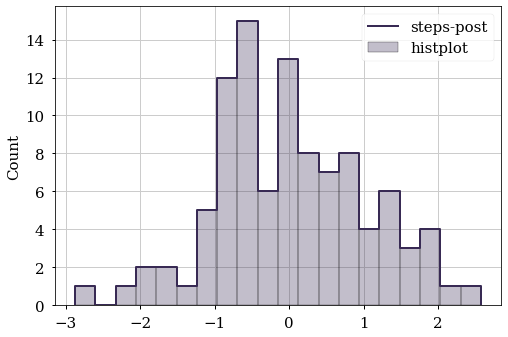

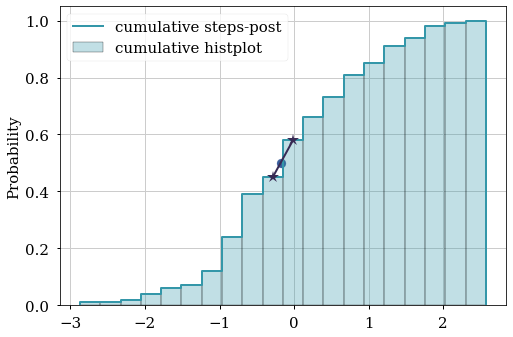

In [11]:
bins = 20  # np.linspace(-3, 3, 25)
rand = np.random.normal(size=100)
h, ed = np.histogram(rand, bins=bins)
histplot_from_nphist(h, ed, label="steps-post")
sns.histplot(rand, bins=ed, label="histplot", alpha=0.3)
plt.legend()

ch = np.cumsum(h) / np.sum(h)
histplot_from_nphist(
    ch,
    ed,
    nfig=2,
    label="cumulative steps-post",
    color=colorlist[2],
)
sns.histplot(
    rand,
    bins=ed,
    label="cumulative histplot",
    alpha=0.3,
    cumulative=True,
    color=colorlist[2],
    stat="probability",
)

q = 0.5
val, yy, xx = interpolate_quantile_value(q, ed, h, verbose=True)
print(val)
plt.plot(xx, yy, marker="*", ms=12)
plt.scatter(val, q, s=80)
plt.legend()

val = interpolate_quantile_value(q, ed, h, offset=3, offset_type="underflow")
print(val)

val = interpolate_quantile_value(q, ed, h, offset=3, offset_type="overflow")
print(val)


## rate plots

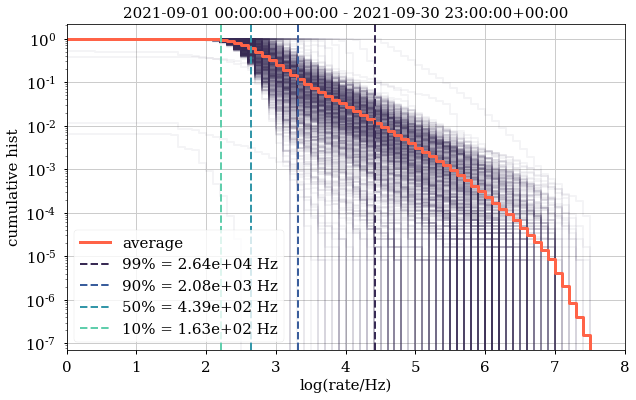

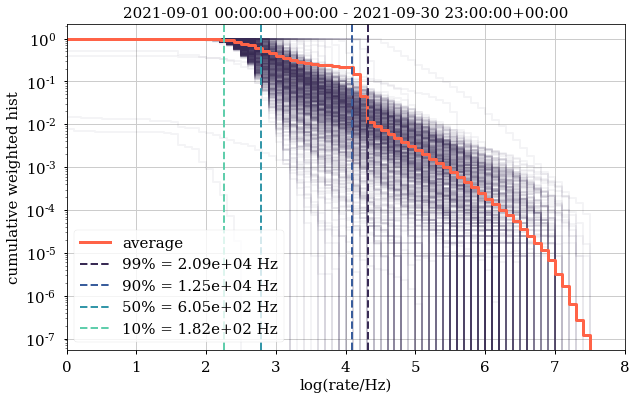

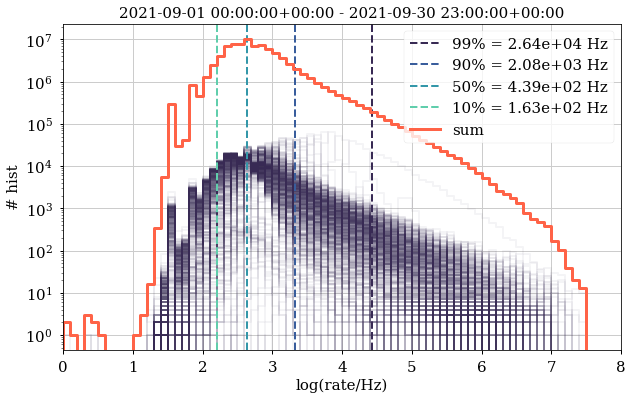

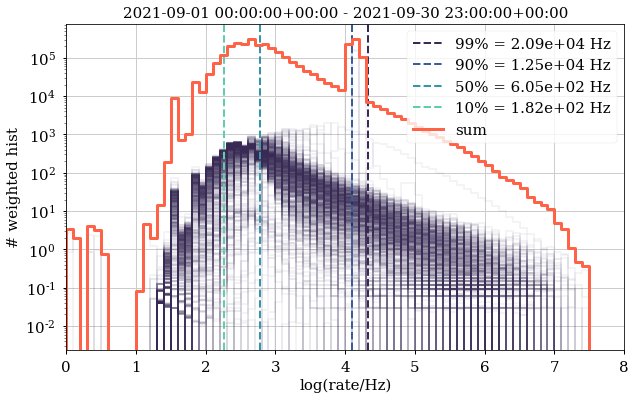

In [42]:
## total rates, cumulative rates, per hour
# NO FILTER selection
plt.figure(1, figsize=(10, 6))
plt.figure(2, figsize=(10, 6))
plt.figure(3, figsize=(10, 6))
plt.figure(4, figsize=(10, 6))

timestamp = np.datetime64("2021-09-30T23:00:00")
mask = good_trb_series.timestamp <= pd.Timestamp(timestamp, tz="utc")
mask &= good_trb_series["filter"] == 0
kws = dict(alpha=0.05, color=colorlist[0])
for _, trb in good_trb_series[mask].iterrows():
    ## cumulative rate hist
    cs = np.cumsum(trb.rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    histplot_from_nphist(cs[::-1], trb.rate_bins, nfig=1, **kws)
    ## cumulative weighted rate hist
    cs = np.cumsum(trb.weighted_rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    histplot_from_nphist(cs[::-1], trb.rate_bins, nfig=2, **kws)
    ## rate hist
    histplot_from_nphist(trb.rate_hist, trb.rate_bins, nfig=3, **kws)
    ## weighted rate hist
    histplot_from_nphist(trb.weighted_rate_hist, trb.rate_bins, nfig=4, **kws)

rate_sum = good_trb_series[mask].rate_hist.sum()
cs = np.cumsum(rate_sum[::-1]).astype(float)
cs /= cs[-1]
histplot_from_nphist(
    cs[::-1], trb.rate_bins, nfig=1, label="average", color="tomato", lw=3
)

weighted_rate_sum = good_trb_series[mask].weighted_rate_hist.sum()
wcs = np.cumsum(weighted_rate_sum[::-1]).astype(float)
wcs /= wcs[-1]
histplot_from_nphist(
    wcs[::-1], trb.rate_bins, nfig=2, label="average", color="tomato", lw=3
)

quantiles = [0.99, 0.9, 0.5, 0.1]
for i, q in enumerate(quantiles):
    thresh = interpolate_quantile_value(q, trb.rate_bins, rate_sum)
    if thresh is not None:
        plt.figure(1)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )
        plt.figure(3)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )

    thresh = interpolate_quantile_value(
        q,
        trb.rate_bins,
        weighted_rate_sum,
    )
    if thresh is not None:
        plt.figure(2)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )
        plt.figure(4)
        plt.axvline(
            thresh,
            label=f"{int(q*100)}% = {10**thresh:1.2e} Hz",
            ls="--",
            color=colorlist[i % len(colorlist)],
        )

histplot_from_nphist(rate_sum, trb.rate_bins, nfig=3, label="sum", color="tomato", lw=3)
histplot_from_nphist(
    weighted_rate_sum, trb.rate_bins, nfig=4, label="sum", color="tomato", lw=3
)


plt.figure(1)
plt.xlim(0, 8)
plt.ylabel("cumulative hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=3, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/no_filter_cumulative_rate.png", bbox_inches="tight")

plt.figure(2)
plt.xlim(0, 8)
plt.ylabel("cumulative weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=3, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/no_filter_weighted_cumulative_rate.png", bbox_inches="tight")

plt.figure(3)
plt.xlim(0, 8)
plt.ylabel("# hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/no_filter_rate.png", bbox_inches="tight")

plt.figure(4)
plt.xlim(0, 8)
plt.ylabel("# weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/no_filter_weighted_rate.png", bbox_inches="tight")


### same plot, different wavelength filter

In [46]:
## total rates, cumulative rates, per hour
# NO FILTER selection
plt.figure(1, figsize=(10, 6))
plt.figure(2, figsize=(10, 6))
plt.figure(3, figsize=(10, 6))
plt.figure(4, figsize=(10, 6))

timestamp = np.datetime64("2021-09-30T23:00:00")
for wavelen in good_trb_series["filter"].unique():
    mask = good_trb_series.timestamp <= pd.Timestamp(timestamp, tz="utc")
    mask &= good_trb_series["filter"] == wavelen
    kws = dict(alpha=0.05, color=colorlist[0])
    #for _, trb in good_trb_series[mask].iterrows():
    #    ## cumulative rate hist
    #    cs = np.cumsum(trb.rate_hist[::-1]).astype(float)
    #    cs /= cs[-1]
    #    histplot_from_nphist(cs[::-1], trb.rate_bins, nfig=1, **kws)
    #    ## cumulative weighted rate hist
    #    cs = np.cumsum(trb.weighted_rate_hist[::-1]).astype(float)
    #    cs /= cs[-1]
    #    histplot_from_nphist(cs[::-1], trb.rate_bins, nfig=2, **kws)
    #    ## rate hist
    #    histplot_from_nphist(trb.rate_hist, trb.rate_bins, nfig=3, **kws)
    #    ## weighted rate hist
    #    histplot_from_nphist(trb.weighted_rate_hist, trb.rate_bins, nfig=4, **kws)

    rate_sum = good_trb_series[mask].rate_hist.sum()
    cs = np.cumsum(rate_sum[::-1]).astype(float)
    cs /= cs[-1]
    histplot_from_nphist(
        cs[::-1], trb.rate_bins, nfig=1, label=f"{wavelen} nm", lw=3, color=wavelength_to_rgb(wavelen)
    )

    weighted_rate_sum = good_trb_series[mask].weighted_rate_hist.sum()
    wcs = np.cumsum(weighted_rate_sum[::-1]).astype(float)
    wcs /= wcs[-1]
    histplot_from_nphist(
        wcs[::-1], trb.rate_bins, nfig=2, label=f"{wavelen} nm", lw=3, color=wavelength_to_rgb(wavelen)
    )

    histplot_from_nphist(rate_sum, trb.rate_bins, nfig=3, label=f"{wavelen} nm", lw=3, color=wavelength_to_rgb(wavelen))
    histplot_from_nphist(
        weighted_rate_sum, trb.rate_bins, nfig=4, label=f"{wavelen} nm", lw=3, color=wavelength_to_rgb(wavelen)
    )


plt.figure(1)
plt.xlim(0, 8)
plt.ylabel("cumulative hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=3, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/all_filter_cumulative_rate.png", bbox_inches="tight")

plt.figure(2)
plt.xlim(0, 8)
plt.ylabel("cumulative weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=3, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/all_filter_weighted_cumulative_rate.png", bbox_inches="tight")

plt.figure(3)
plt.xlim(0, 8)
plt.ylabel("# hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/all_filter_rate.png", bbox_inches="tight")

plt.figure(4)
plt.xlim(0, 8)
plt.ylabel("# weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc=1, ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.savefig("../no_git/plot_dump/all_filter_weighted_rate.png", bbox_inches="tight")


IndexError: invalid index to scalar variable.

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

### analyze the weird failure (?) on sept. 24

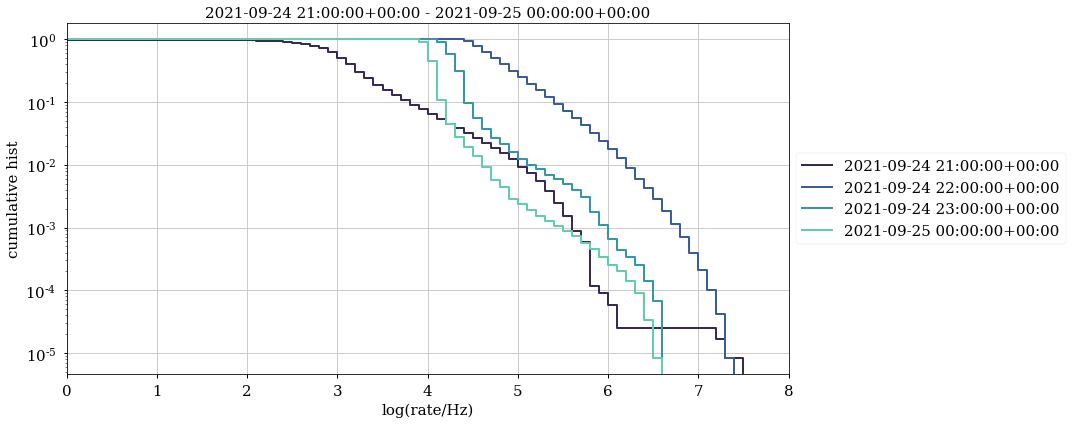

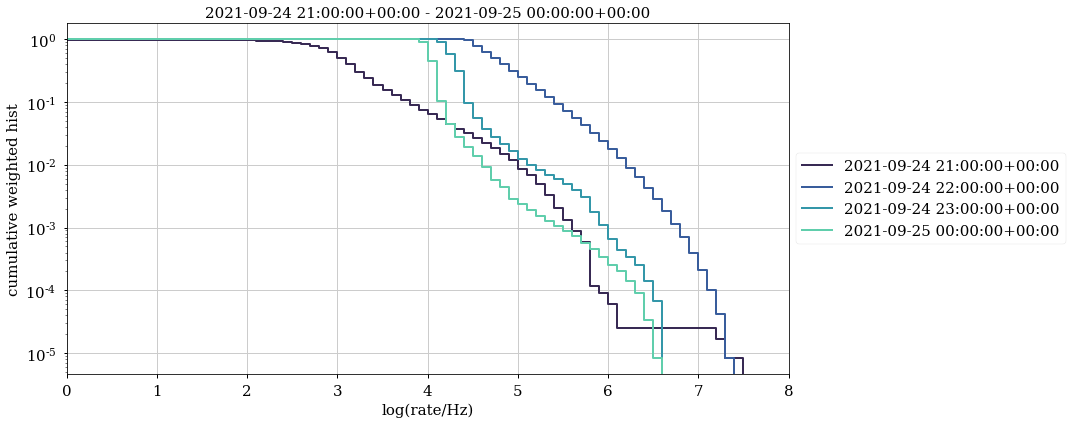

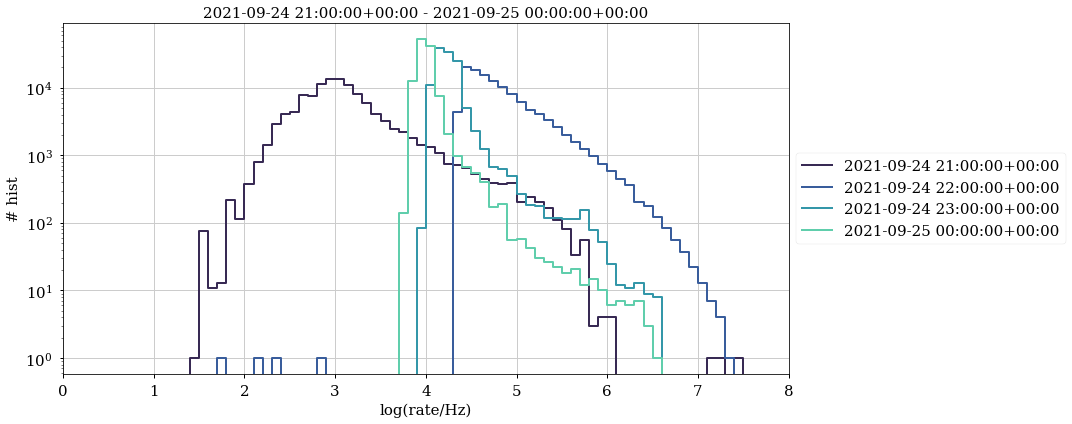

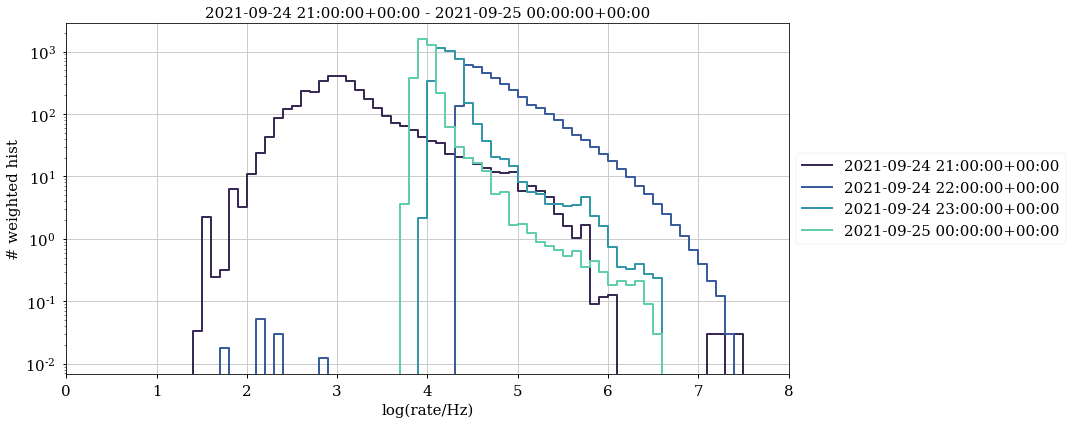

In [18]:
## total rates, cumulative rates, per hour
plt.figure(1, figsize=(15, 6))
plt.figure(2, figsize=(15, 6))
plt.figure(3, figsize=(15, 6))
plt.figure(4, figsize=(15, 6))

mask = good_trb_series.timestamp <= pd.Timestamp(np.datetime64("2021-09-25T00:00:00"), tz="utc")
mask &= good_trb_series.timestamp >= pd.Timestamp(np.datetime64("2021-09-24T21:00:00"), tz="utc")
kws = dict(alpha=1)#, color=colorlist[0])
for _, trb in good_trb_series[mask].iterrows():
    ## cumulative rate hist
    cs = np.cumsum(trb.rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    histplot_from_nphist(cs[::-1], trb.rate_bins, nfig=1, label=trb.timestamp, **kws)
    ## cumulative weighted rate hist
    cs = np.cumsum(trb.weighted_rate_hist[::-1]).astype(float)
    cs /= cs[-1]
    histplot_from_nphist(cs[::-1], trb.rate_bins, nfig=2, label=trb.timestamp, **kws)
    ## rate hist
    histplot_from_nphist(trb.rate_hist, trb.rate_bins, nfig=3, label=trb.timestamp, **kws)
    ## weighted rate hist
    histplot_from_nphist(trb.weighted_rate_hist, trb.rate_bins, nfig=4, label=trb.timestamp, **kws)

plt.figure(1)
plt.xlim(0, 8)
plt.ylabel("cumulative hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.tight_layout()
plt.savefig("../no_git/plot_dump/cumulative_rate.png", bbox_inches="tight")

plt.figure(2)
plt.xlim(0, 8)
plt.ylabel("cumulative weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.tight_layout()
plt.savefig("../no_git/plot_dump/weighted_cumulative_rate.png", bbox_inches="tight")

plt.figure(3)
plt.xlim(0, 8)
plt.ylabel("# hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.tight_layout()
plt.savefig("../no_git/plot_dump/rate.png", bbox_inches="tight")

plt.figure(4)
plt.xlim(0, 8)
plt.ylabel("# weighted hist")
plt.xlabel("log(rate/Hz)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.semilogy()
plt.title(
    f"{good_trb_series[mask].timestamp.min()} - {good_trb_series[mask].timestamp.max()}"
)
plt.tight_layout()
plt.savefig("../no_git/plot_dump/weighted_rate.png", bbox_inches="tight")


In [15]:
## percentiles of rate per hour
quantiles = [0.1, 0.5, 0.9, 0.99]
quantile_values = []
for _, trb in good_trb_series.iterrows():
    tmp = {"timestamp": trb.timestamp, "hour": _}
    for q in quantiles:
        tmp[f"q_{int(q*100)}"] = interpolate_quantile_value(
            q, trb.rate_bins, trb.rate_hist
        )
        tmp[f"q_{int(q*100)}_weighted"] = interpolate_quantile_value(
            q, trb.rate_bins, trb.weighted_rate_hist
        )
    quantile_values.append(tmp)
quantile_values = pd.DataFrame(quantile_values)
quantile_values


timestamp  hour      q_10  q_10_weighted      q_50  \
0          2021-09-01 00:00:00+00:00     0  2.274443       2.277693  2.658213   
1          2021-09-01 01:00:00+00:00     1  2.333219       2.337404  2.753286   
2   2021-09-01 03:07:58.986000+00:00     2  2.153499       2.157564  2.595697   
3          2021-09-01 04:00:00+00:00     3  2.031860       2.040465  2.384690   
4          2021-09-01 05:00:00+00:00     4  2.048006       2.054237  2.381584   
..                               ...   ...       ...            ...       ...   
736        2021-09-30 19:00:00+00:00   736  2.573832       2.576417  2.921455   
737        2021-09-30 20:00:00+00:00   737  2.631757       2.635483  3.034237   
738        2021-09-30 21:00:00+00:00   738  2.701601       2.702635  3.093290   
739        2021-09-30 22:00:00+00:00   739  2.667437       2.669426  3.039750   
740        2021-09-30 23:00:00+00:00   740  2.408639       2.412102  2.709421   

     q_50_weighted      q_90  q_90_weighted      q_99  q_99_weighted  
0         2.658063  3.412157       3.408721  4.607658       4.602443  
1         2.748546  3.629318       3.619200  4.571303       4.553158  
2         2.595744  3.315925       3.316929  4.492543       4.489250  
3         2.386559  2.747567       2.746016  3.299993       3.294870  
4         2.383453  2.709352       2.706602  3.127920       3.124781  
..             ...       ...            ...       ...            ...  
736       2.921863  3.633021       3.637124  4.594407       4.601337  
737       3.033494  3.785948       3.784545  4.885429       4.904168  
738       3.092789  3.665209       3.662778  4.686095       4.685834  
739       3.039607  3.621215       3.623366  4.638673       4.638672  
740       2.709840  3.170163       3.170940  4.031402       4.043583  

[741 rows x 10 columns]

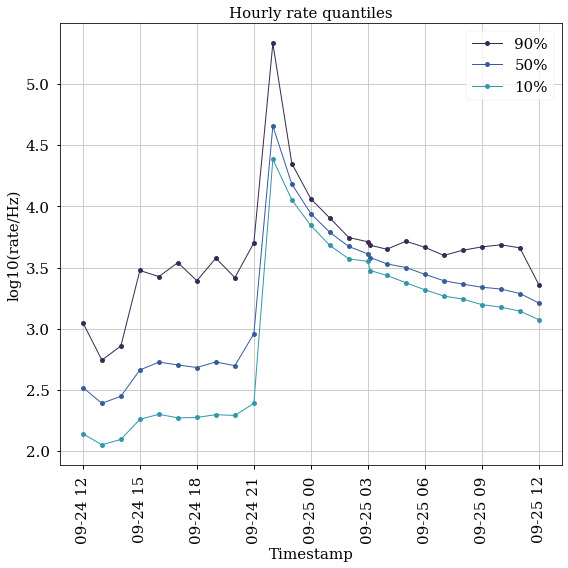

In [19]:
plt.figure(figsize=(8,8))
mask = quantile_values.timestamp <= pd.Timestamp(np.datetime64("2021-09-25T12:00:00"), tz="utc")
mask &= quantile_values.timestamp >= pd.Timestamp(np.datetime64("2021-09-24T12:00:00"), tz="utc")
kws = dict(marker="o", ms=5, lw=1)
plt.plot(
    quantile_values.timestamp[mask], quantile_values.q_90[mask], label="90%", **kws
)
plt.plot(
    quantile_values.timestamp[mask], quantile_values.q_50[mask], label="50%", **kws
)
plt.plot(
    quantile_values.timestamp[mask], quantile_values.q_10[mask], label="10%", **kws
)
plt.ylabel("log10(rate/Hz)")
plt.xlabel("Timestamp")
plt.title("Hourly rate quantiles")
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("../no_git/plot_dump/rate_quantiles_per_hour.png", bbox_inches="tight")


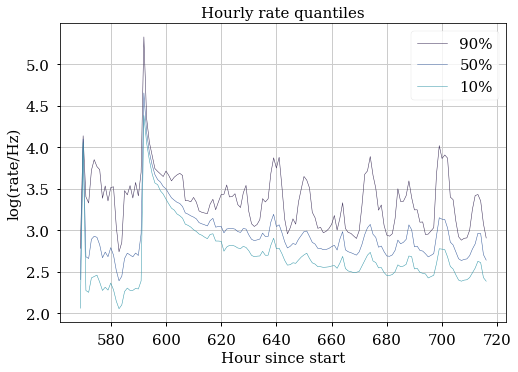

In [ ]:
mask = quantile_values.timestamp <= pd.Timestamp(np.datetime64("2021-09-30T00:00:00"), tz="utc")
mask &= quantile_values.timestamp >= pd.Timestamp(np.datetime64("2021-09-24T00:00:00"), tz="utc")
kws = dict(marker="o", ms=0, lw=0.5)
plt.plot(
    quantile_values.hour[mask], quantile_values.q_90_weighted[mask], label="90%", **kws
)
plt.plot(
    quantile_values.hour[mask], quantile_values.q_50_weighted[mask], label="50%", **kws
)
plt.plot(
    quantile_values.hour[mask], quantile_values.q_10_weighted[mask], label="10%", **kws
)
plt.ylabel("log(rate/Hz)")
plt.xlabel("Hour since start")
plt.title("Hourly rate quantiles")
plt.legend()
plt.savefig("../no_git/plot_dump/rate_quantiles_per_hour.png")


# Analyze specific events

In [205]:
selected_timestamps = [
    np.datetime64("2021-09-04T23:44:09"),
    np.datetime64("2021-09-14T12:11:46"),
    np.datetime64("2021-09-26T03:14:35"),
]


In [5]:
selected_timestamps = [
    np.datetime64("2021-09-24T21:00:00"),
    np.datetime64("2021-09-24T22:00:00"),
    np.datetime64("2021-09-24T23:00:00"),
    np.datetime64("2021-09-25T00:00:00"),
]


In [8]:
## download files if not yet available
for timestamp in selected_timestamps:
    mask = db.dataframe["deviceCode"] == "TUMPMTSPECTROMETER001"
    mask &= db.dataframe["dataProductCode"] == "PMTSD"
    ## select 1h frame around the selected timestamps
    mask &= db.dataframe.dateFrom >= pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    )
    mask &= db.dataframe.dateFrom < (
        pd.Timestamp(np.datetime64(timestamp, "h"), tz="UTC") + np.timedelta64(1, "h")
    )
    if not db.dataframe.synced[mask].all():
        db.update_db_and_load_files(
            db.dataframe[mask],
            output=True,  # print output to console
            download=True,  # download the files
            # save_db=True
        )
        db.save_db()
    else:
        print("did not need to download anything")


did not need to download anything
did not need to download anything
did not need to download anything
did not need to download anything


In [6]:
pmt_specs = []
for timestamp in selected_timestamps:
    # select file with the right data
    mask = db.dataframe.deviceCode == "TUMPMTSPECTROMETER001"
    mask &= db.dataframe.dataProductCode == "PMTSD"
    mask &= db.dataframe.measurement_type.isnull() | (
        db.dataframe.measurement_type == "counts"
    )
    # only synced data
    mask &= db.dataframe.synced

    ## select 1h frame around the biolumi event
    mask &= db.dataframe.dateFrom >= pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    )
    mask &= db.dataframe.dateFrom < pd.Timestamp(
        np.datetime64(timestamp, "h"), tz="UTC"
    ) + np.timedelta64(1, "h")

    # load PMTSpec
    try:
        # select the latest frame that matches the condition
        pmt_specs.append(strawb.sensors.PMTSpec(db.dataframe.filename[mask].iloc[-1]))
        print("that did actually work!")
    except:
        print("that didnt work", db.dataframe.filename[mask].iloc[-1])
        continue


that did actually work!
that did actually work!
that did actually work!
that did actually work!


In [47]:
len(pmtspec.pmt_meta_data.channel_meta_array)

12

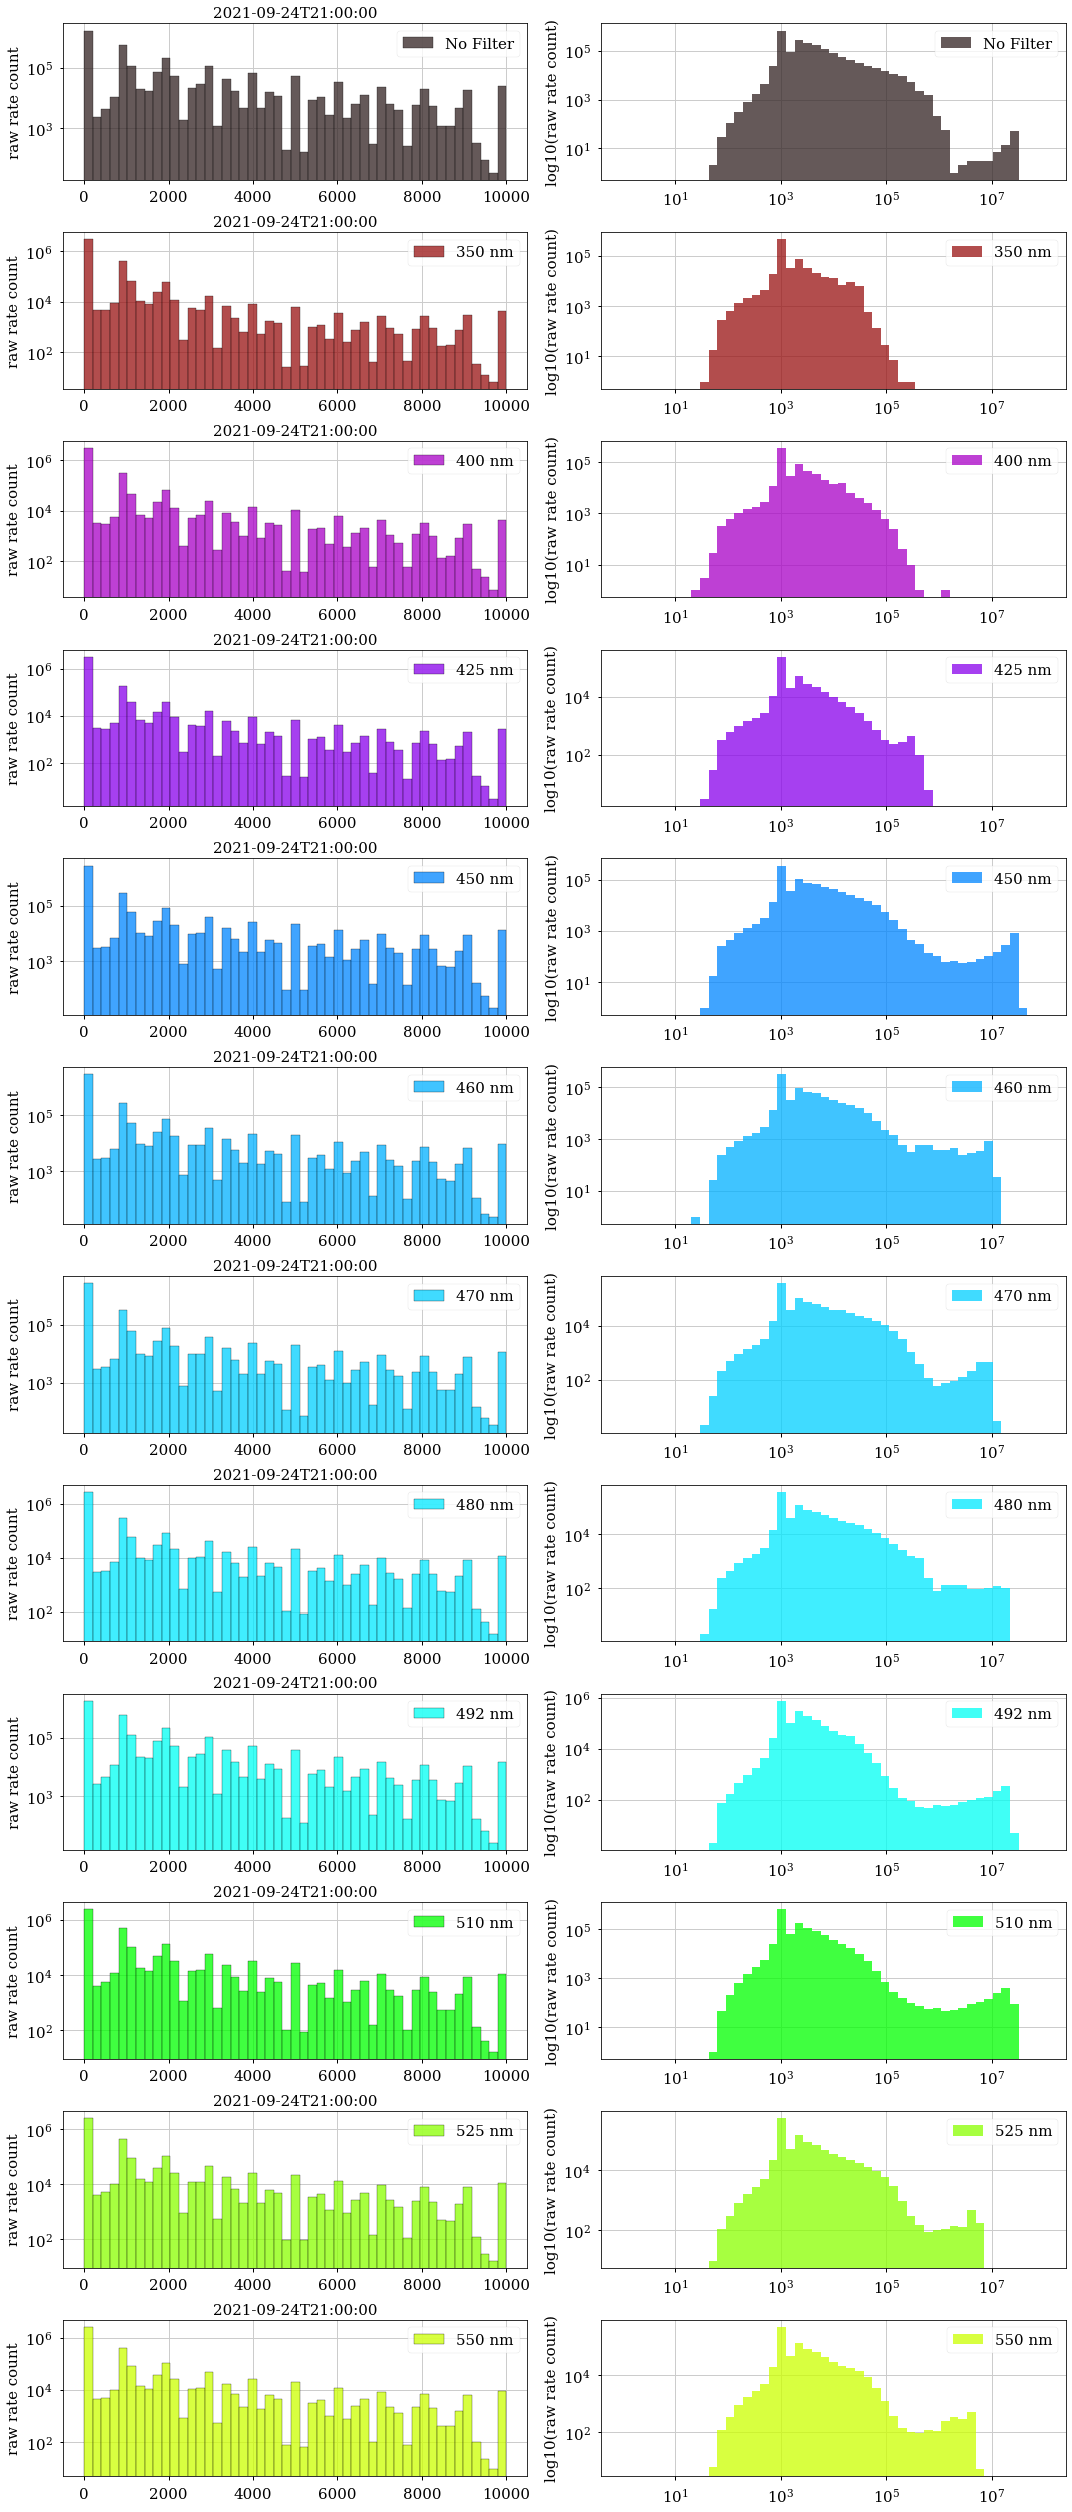

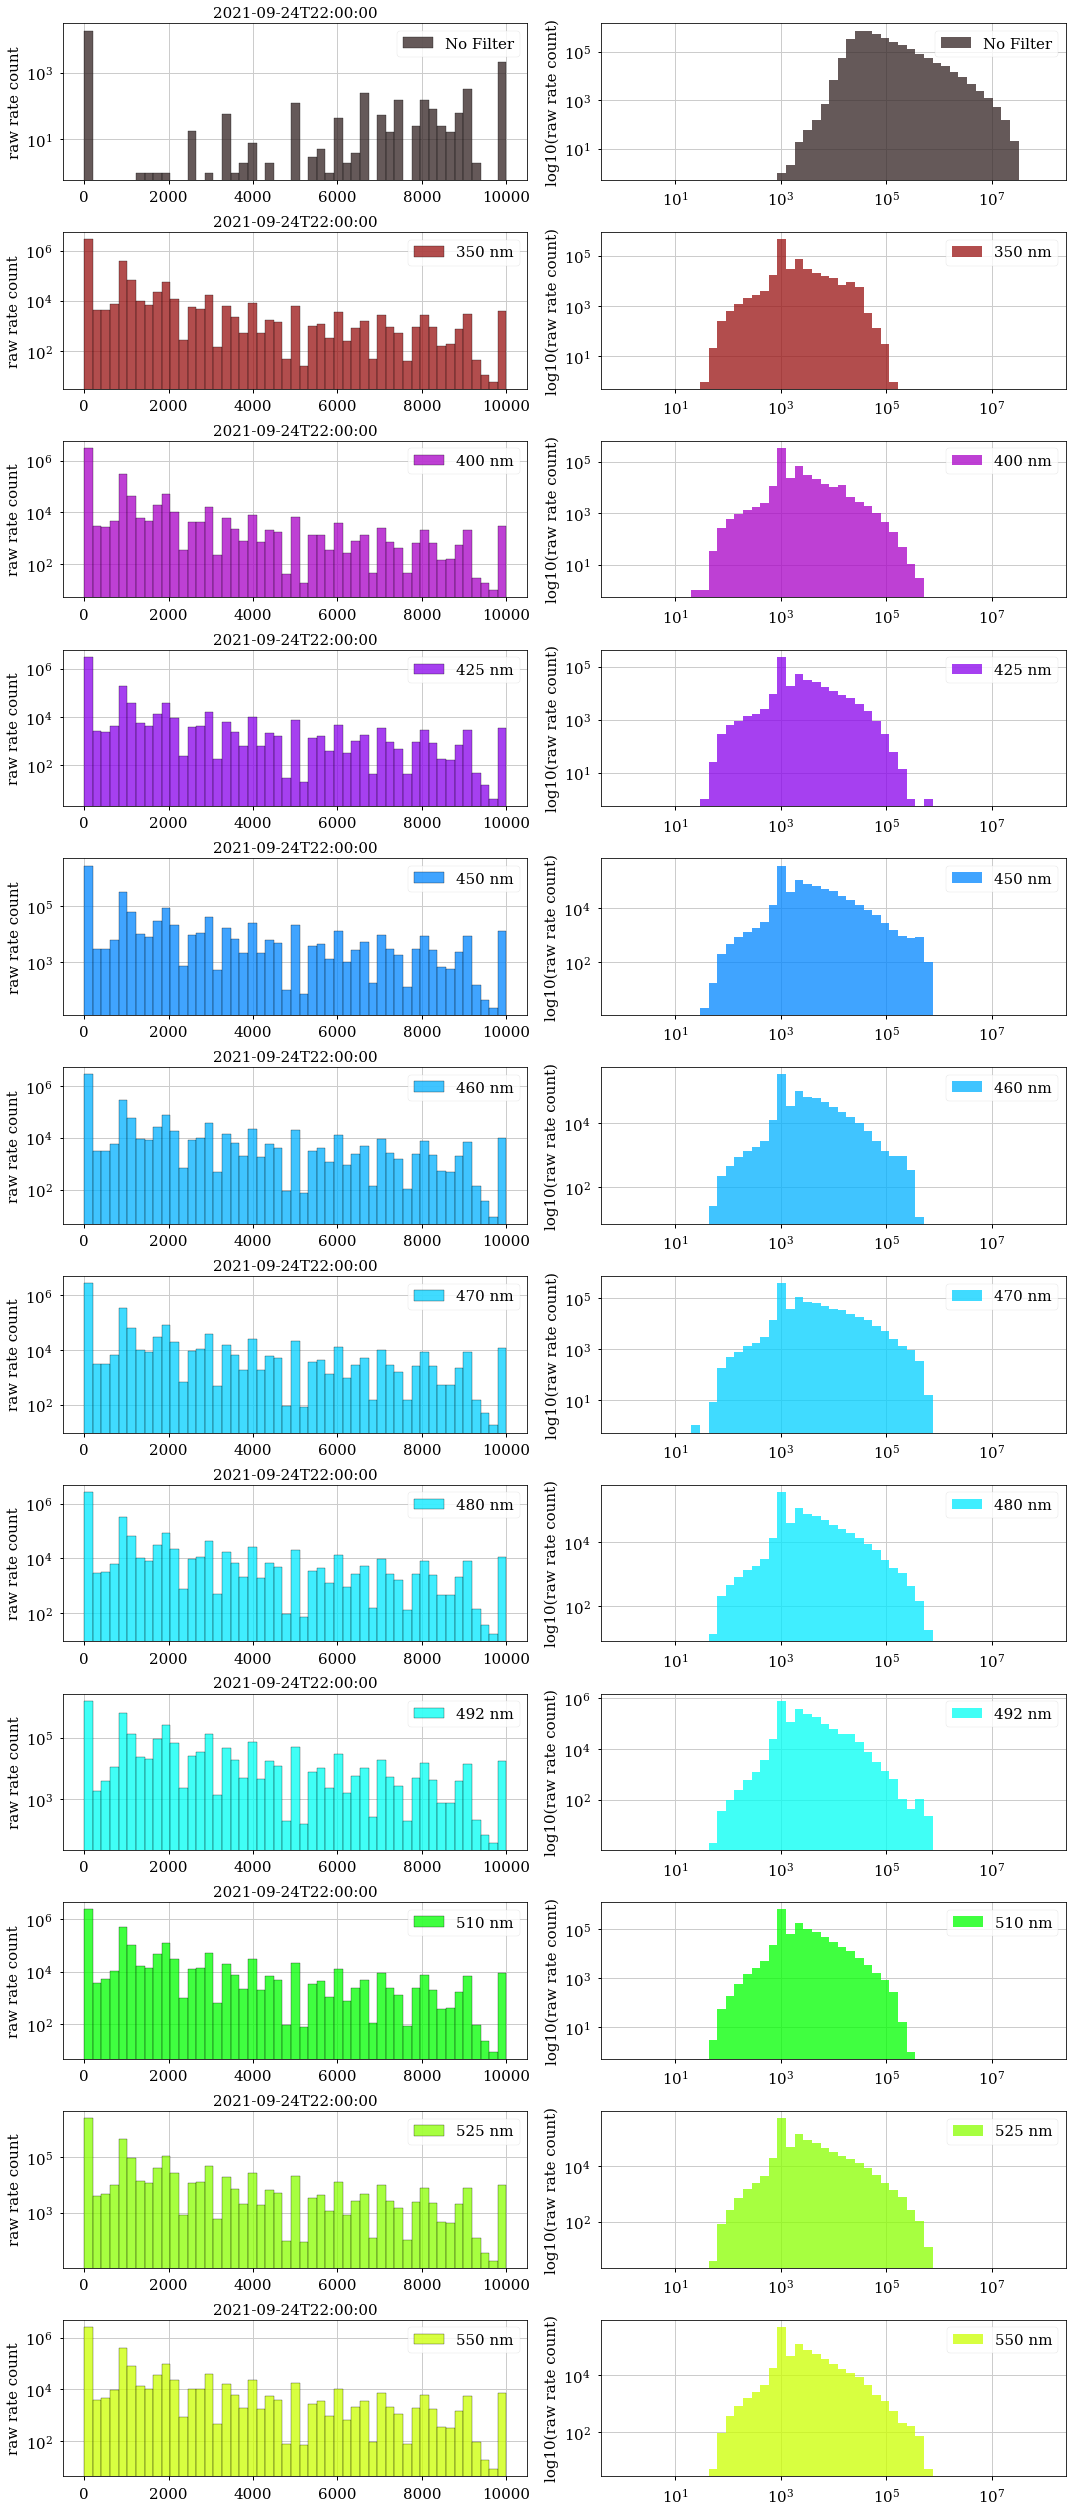

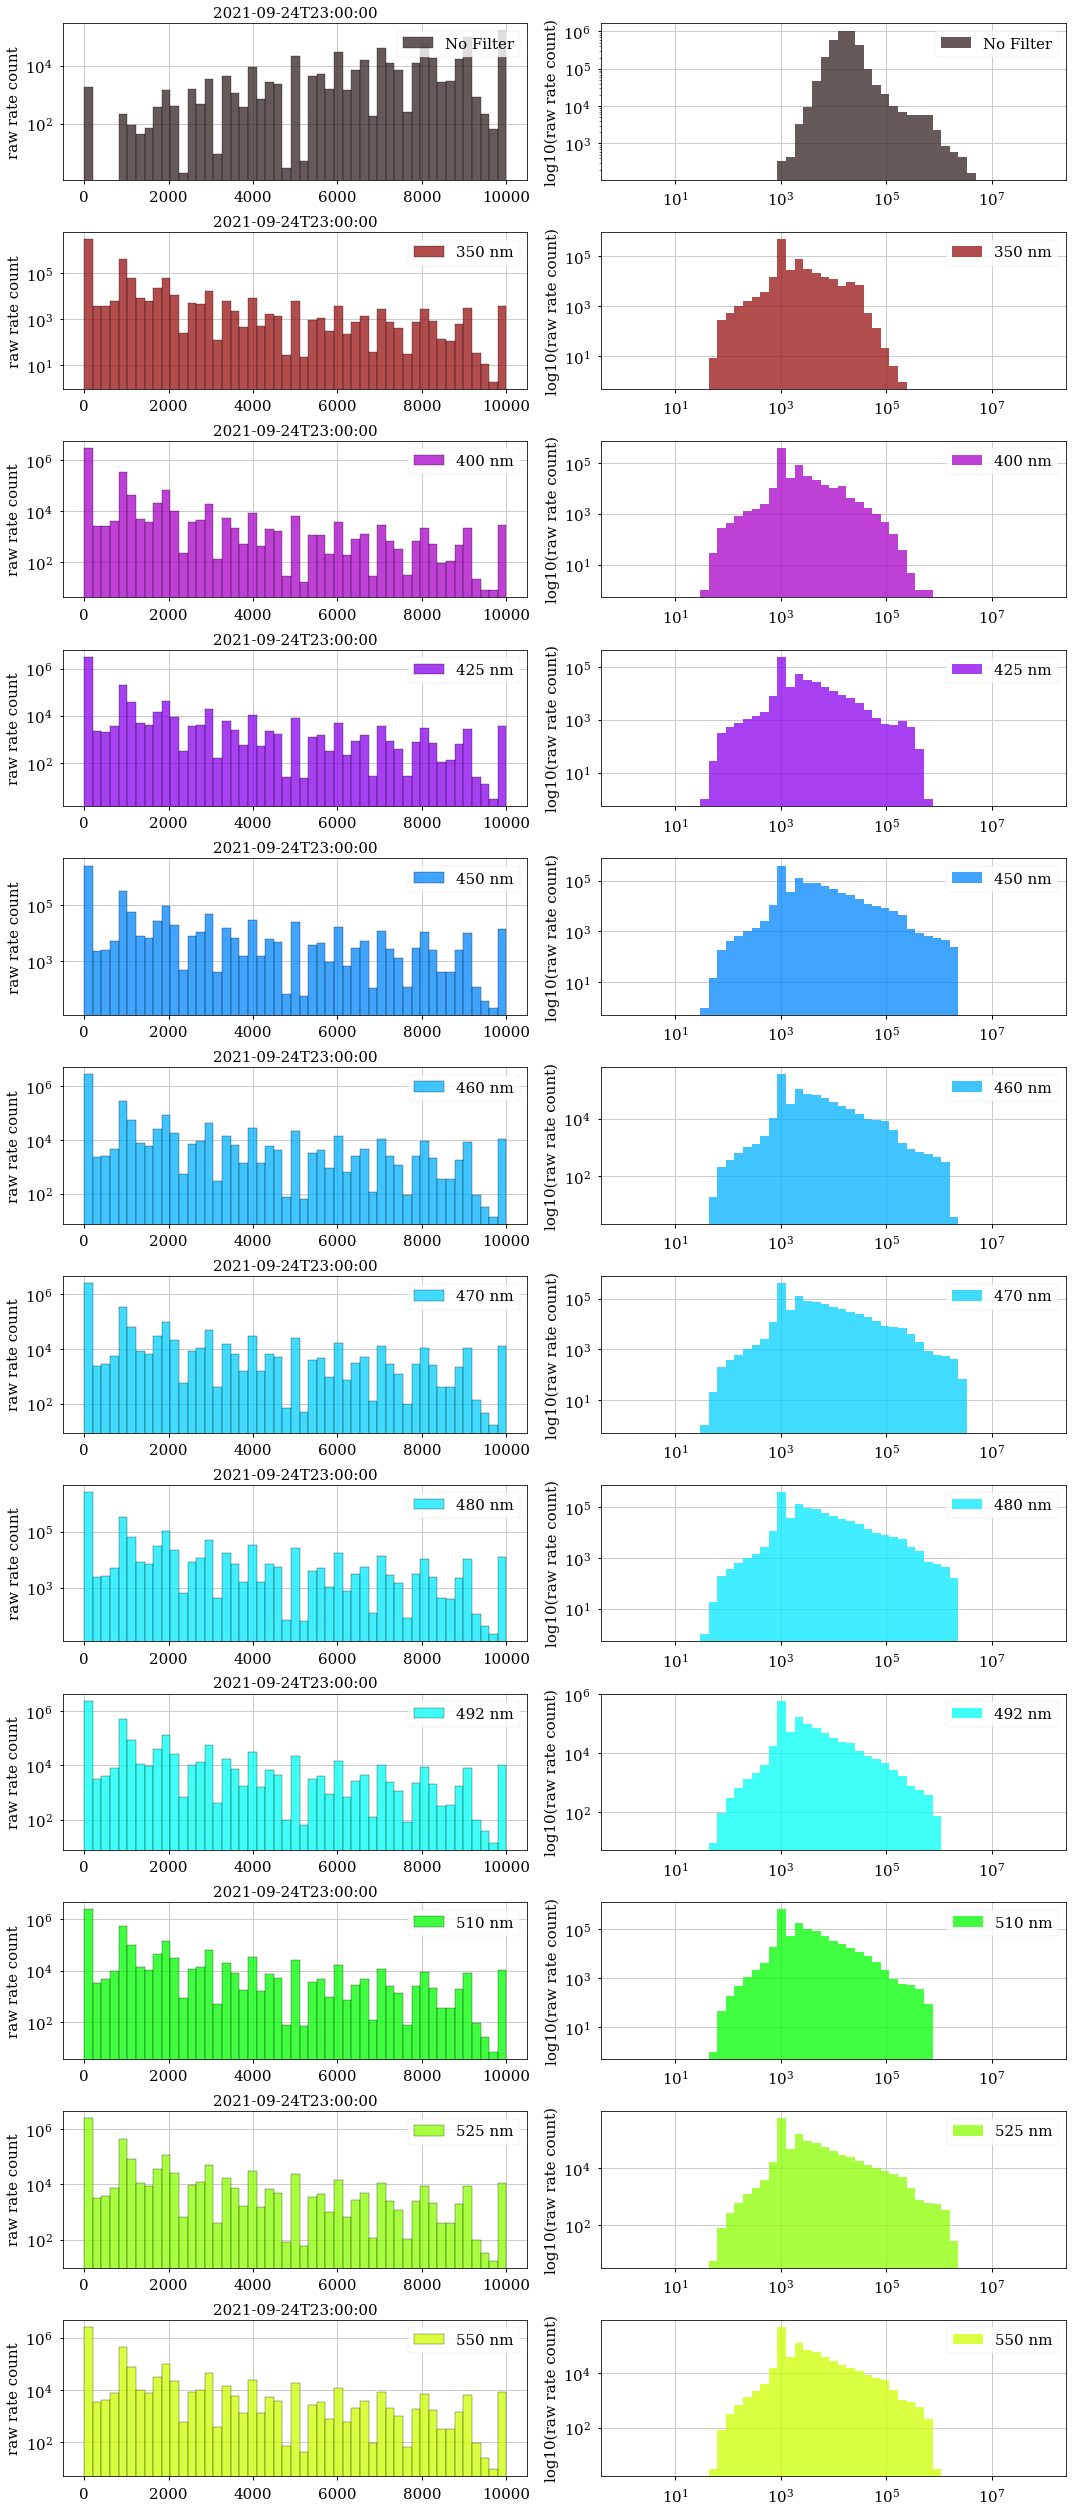

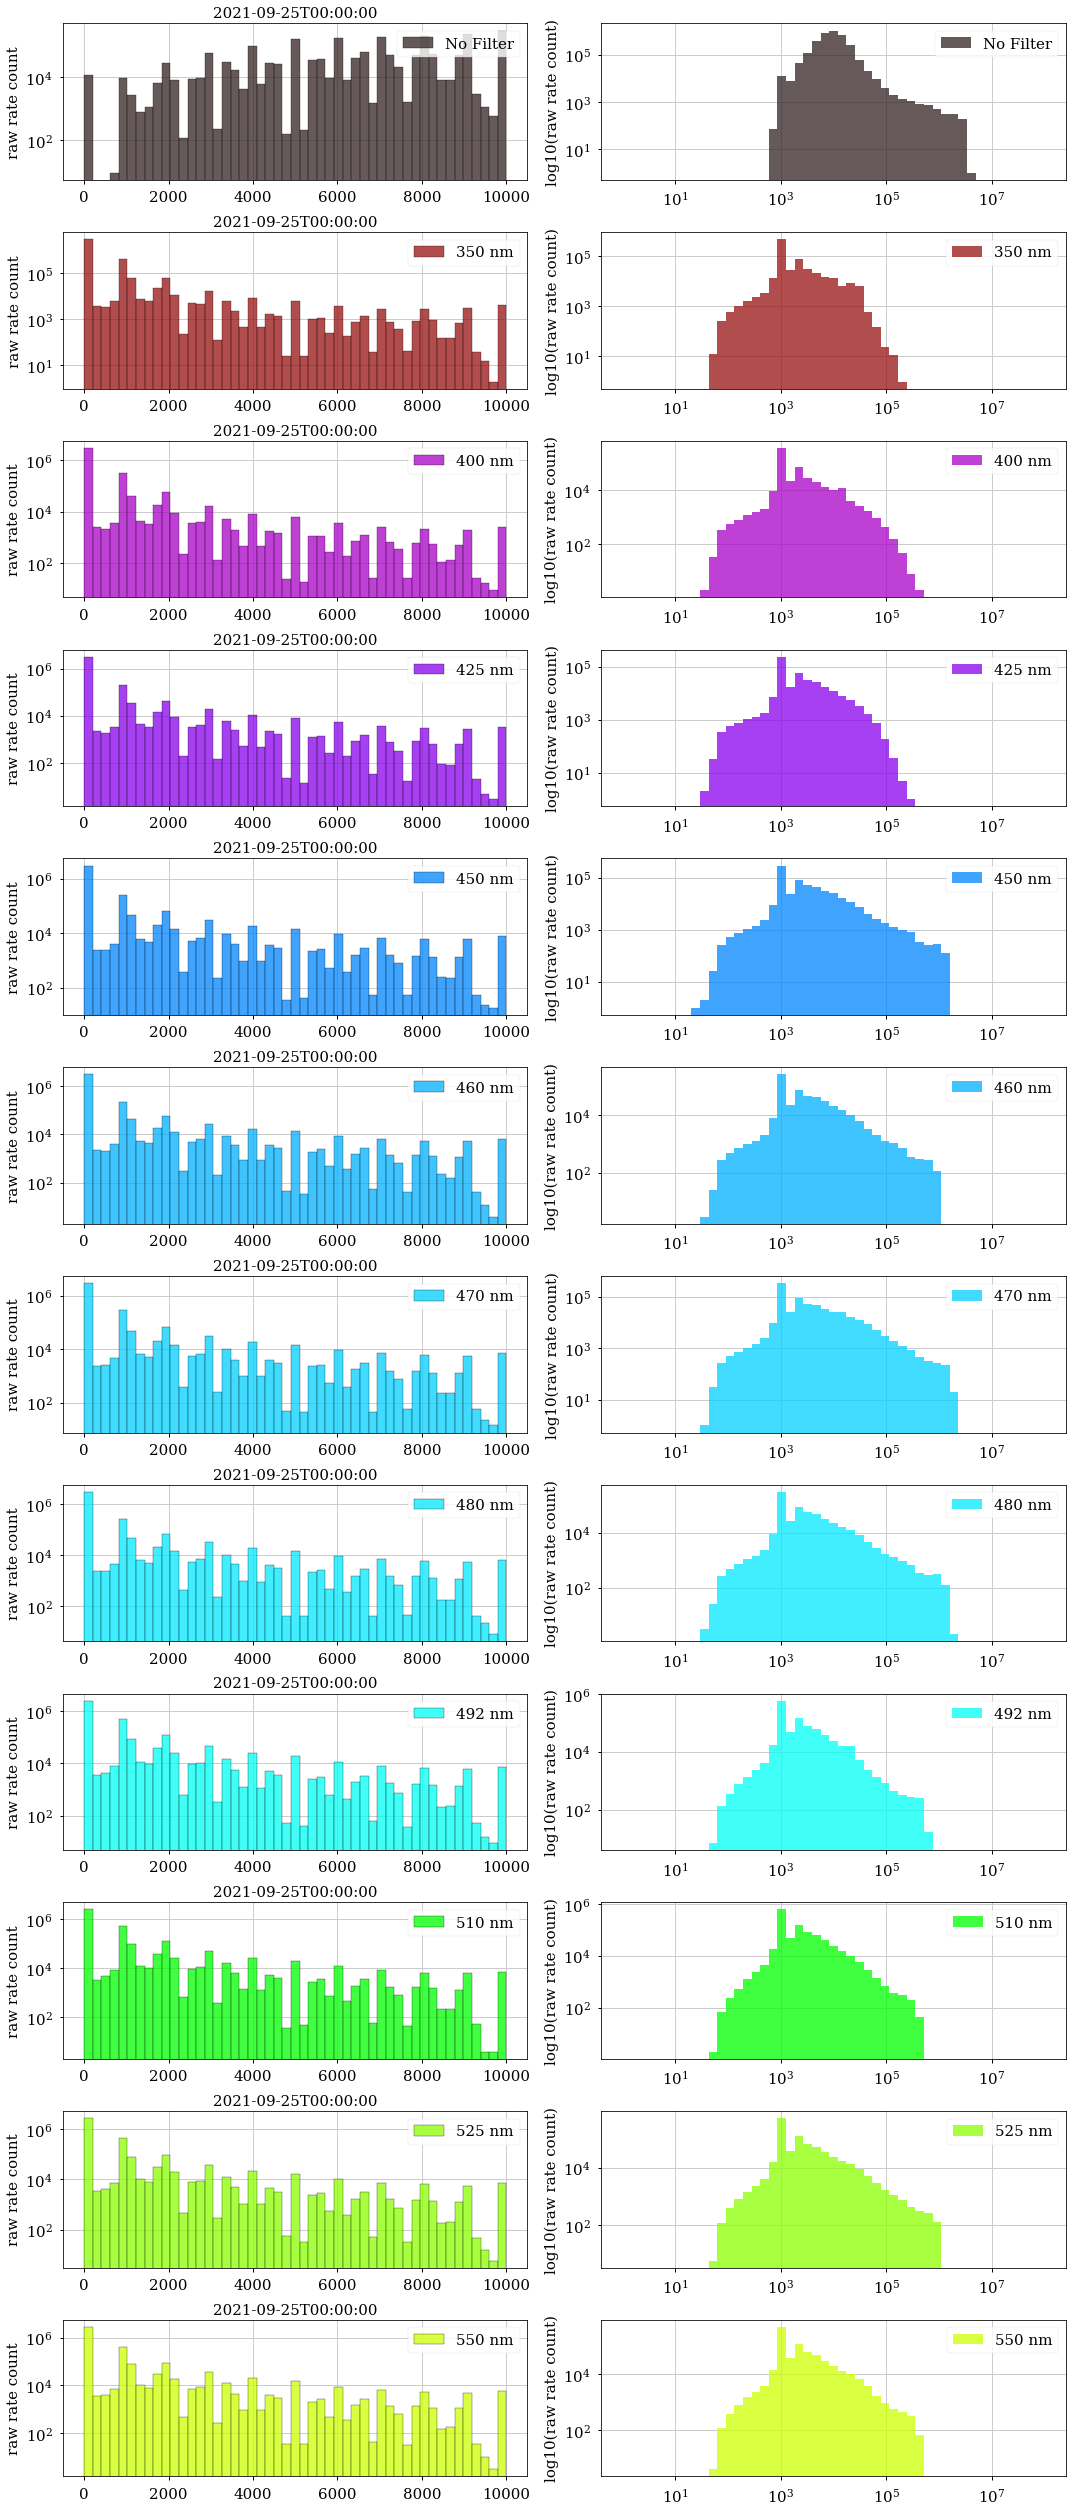

In [49]:
bins_low = np.linspace(0, 1e4)
bins_high = np.logspace(0, 8)
for ind, (pmtspec, timestamp) in enumerate(zip(pmt_specs, selected_timestamps)):
    pmtspec.pmt_meta_data.add_colors(
        plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
    )

    times_ns = (
        pmtspec.trb_rates.rate_time_middle
    )  # strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
    ### select +-2min around biolumi events
    timemask = np.ones(len(times_ns), dtype=bool)
    masked_times_ns = times_ns[timemask]

    f, ax = plt.subplots(ncols=2, nrows=len(pmtspec.pmt_meta_data.channel_meta_array), figsize=(15, 35))
    
    for ii, ch in enumerate(pmtspec.pmt_meta_data.channel_meta_array):
        axes = ax[ii]
        axes[0].set_title(timestamp)
        _ = sns.histplot(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            bins=bins_low,
            ax=axes[0],
        )
        axes[0].set_yscale("log")
        axes[0].legend(loc=1, ncol=2)
        axes[0].set_ylabel("raw rate count")

        _ = sns.histplot(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            bins=bins_high,
            ax=axes[1],
        )
        axes[1].set_yscale("log")
        axes[1].set_xscale("log")
        axes[1].legend(loc=1, ncol=2)
        axes[1].set_ylabel("log10(raw rate count)")
    f.tight_layout()


<Figure size 1080x432 with 0 Axes>

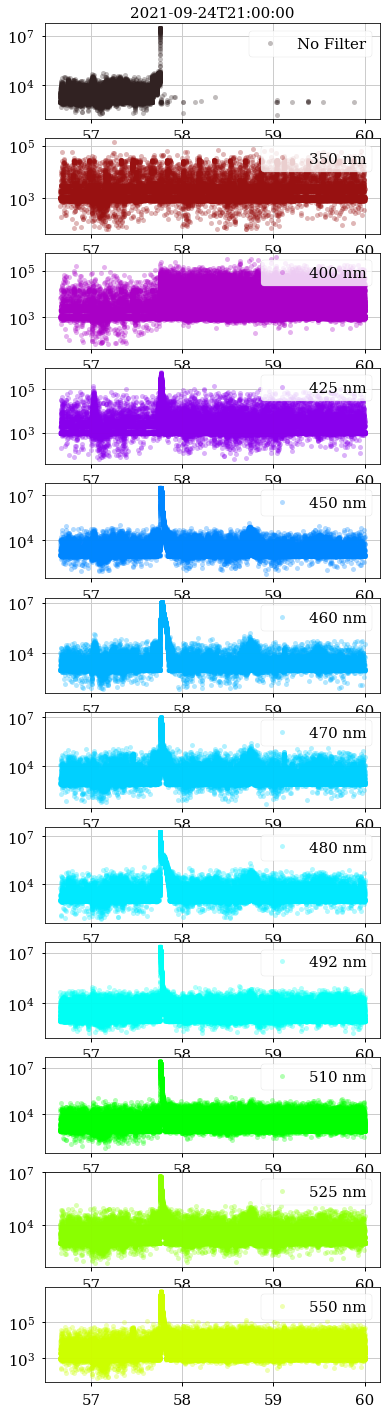

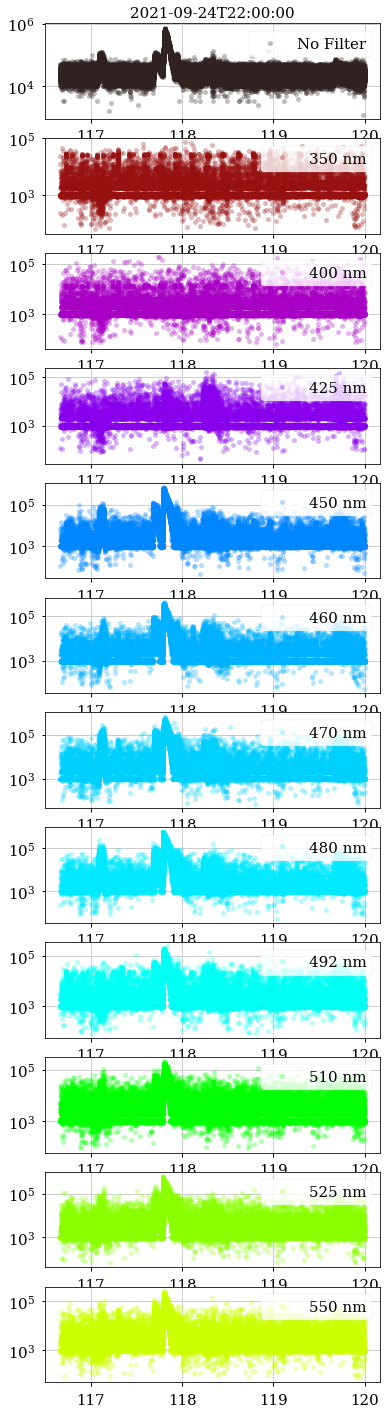

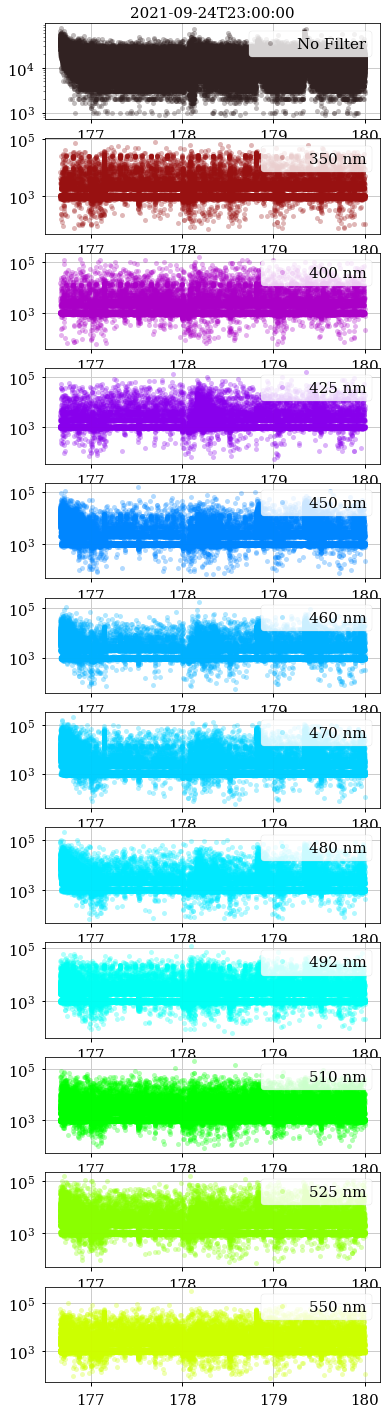

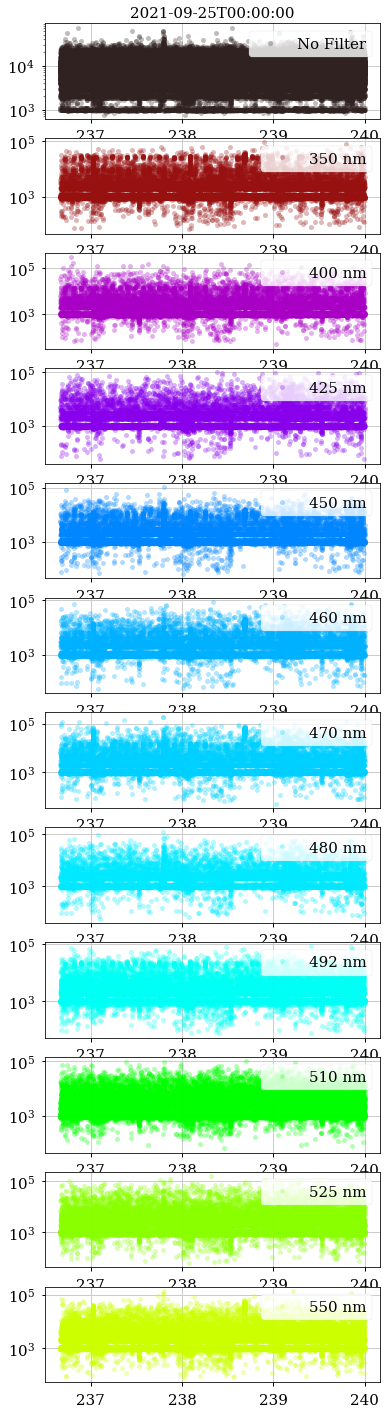

In [54]:
plt.figure(1, figsize=(15, 6))
#plt.figure(2, figsize=(15, 6))
for ind, (pmtspec, timestamp) in enumerate(zip(pmt_specs, selected_timestamps)):

    pmtspec.pmt_meta_data.add_colors(
        plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
    )

    times_ns = pmtspec.trb_rates.rate_time_middle #strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
    ### select +-2min around biolumi events
    timemask = times_ns > 3400 #np.ones(len(times_ns), dtype=bool)
    masked_times_ns = times_ns[timemask]
    f, axes = plt.subplots(nrows=len(pmtspec.pmt_meta_data.channel_meta_array), figsize=(6, 25))
    axes[0].set_title(timestamp)
    for ii, ch in enumerate(pmtspec.pmt_meta_data.channel_meta_array):
        _ = axes[ii].plot(
            (masked_times_ns + ind * 3600) / 60,
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            marker="o",
            lw=0,
            alpha=0.3,
            ms=5,
        )
        axes[ii].legend(loc=1, ncol=2)
        axes[ii].set_yscale("log")
    plt.show()


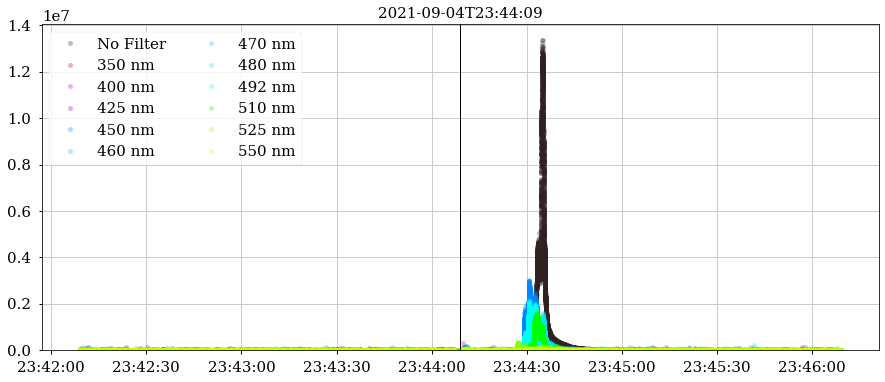

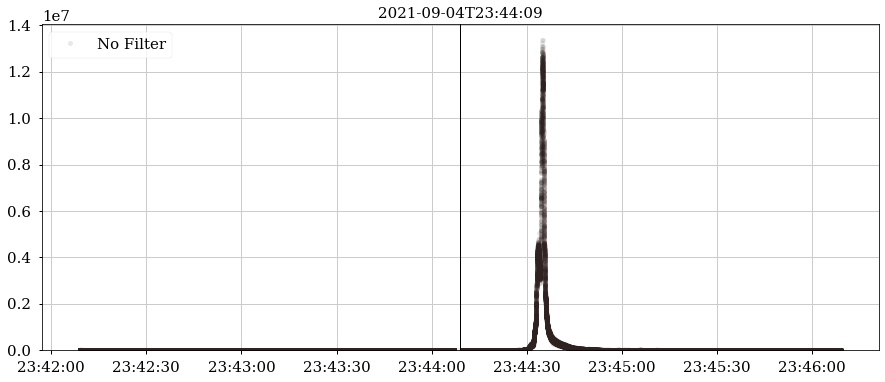

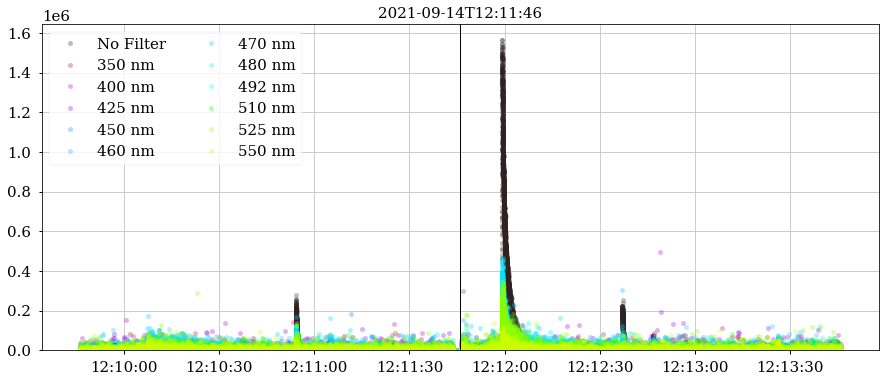

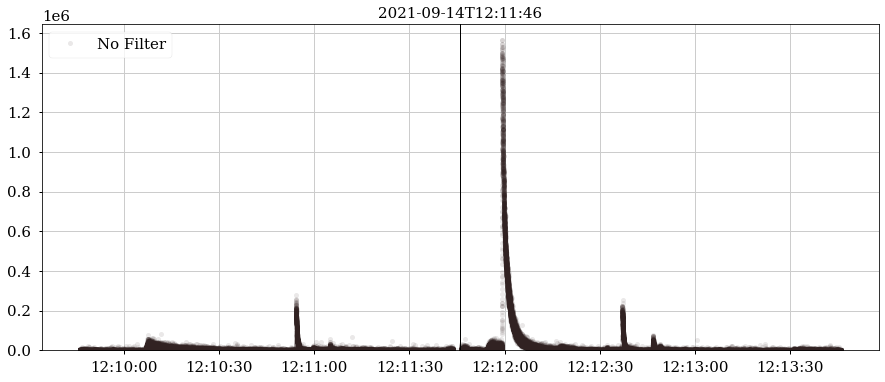

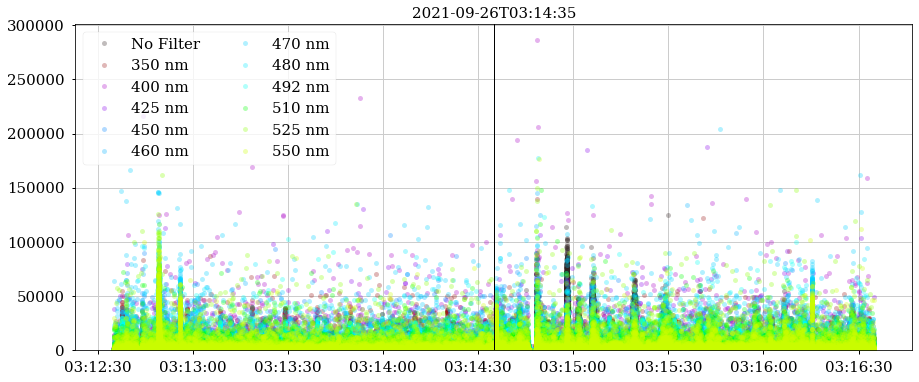

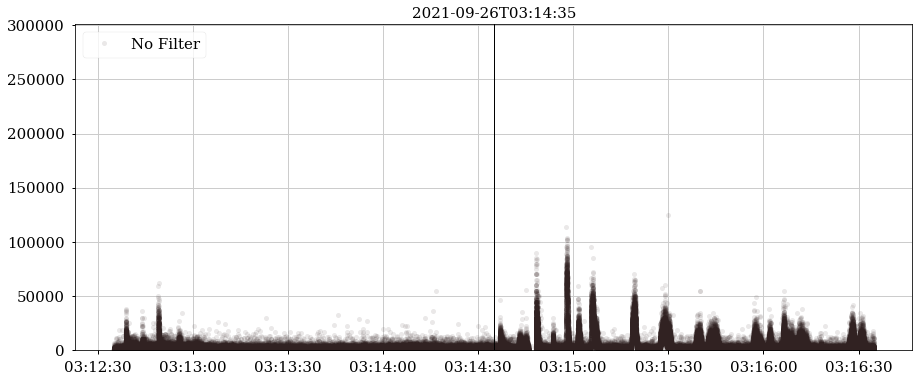

In [ ]:
for pmtspec, timestamp in zip(pmt_specs, selected_timestamps):

    pmtspec.pmt_meta_data.add_colors(
        plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
    )

    times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
    ### select +-2min around biolumi events
    timemask = times_ns >= timestamp - np.timedelta64(
        2, "m"
    )  # - np.timedelta64(30, "s")
    timemask &= times_ns <= timestamp + np.timedelta64(
        2, "m"
    )  # + np.timedelta64(30, "s")
    masked_times_ns = times_ns[timemask]

    plt.figure(figsize=(15, 6))
    plt.title(timestamp)
    for ch in pmtspec.pmt_meta_data.channel_meta_array:
        _ = plt.plot(
            masked_times_ns,
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            marker="o",
            lw=0,
            alpha=0.3,
            ms=5,
        )
    plt.legend(loc=2, ncol=2)
    plt.axvline(timestamp, lw=1, color="k")
    plt.ylim(0, np.max(pmtspec.trb_rates.rate.T[timemask]) * 1.05)

    plt.figure(figsize=(15, 6))
    plt.title(timestamp)
    for ch in pmtspec.pmt_meta_data.channel_meta_array[
        pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
    ]:
        _ = plt.plot(
            masked_times_ns,
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
            color=wavelength_to_rgb(ch, gamma=0.4),
            label=ch["label"],
            marker="o",
            lw=0,
            alpha=0.1,
            ms=5,
        )
    plt.legend(loc=2, ncol=2)
    plt.axvline(timestamp, lw=1, color="k")
    plt.ylim(0, np.max(pmtspec.trb_rates.rate.T[timemask]) * 1.05)


## zoom ins

In [13]:
import colorsys
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.colors as mc


In [14]:
def change_color_ld(color, amount=0.2):
    """slightly change the color lightness/darkness"""
    if not colorsys:
        print("Cannot change color.")
        return color
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    c_new = np.clip(c[1] + amount, 0, 1)
    return colorsys.hls_to_rgb(c[0], c_new, c[2])


In [15]:
filter_N = 100


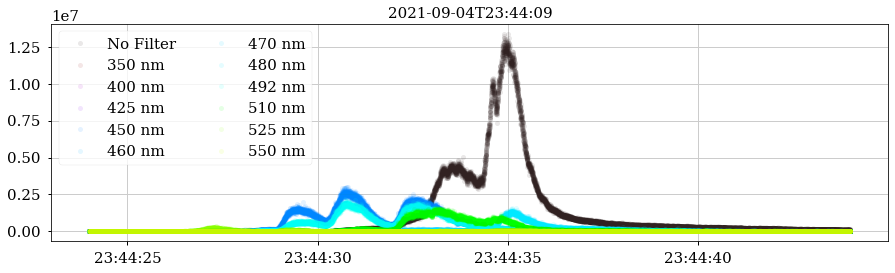

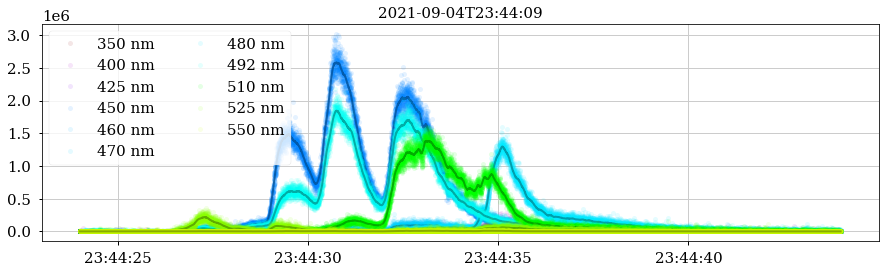

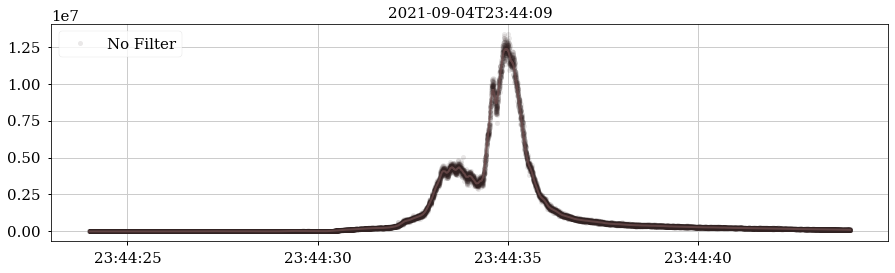

In [212]:
pmtspec, timestamp = pmt_specs[0], selected_timestamps[0]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(15, "s")
timemask &= times_ns <= timestamp + np.timedelta64(35, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=2, ncol=2)

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
    plt.plot(
        masked_times_ns,
        uniform_filter1d(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
        ),
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), -0.2),
        lw=2,
        alpha=0.8,
    )
plt.legend(loc=2, ncol=2)

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
    plt.plot(
        masked_times_ns,
        uniform_filter1d(
            pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
        ),
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), +0.2),
        lw=2,
        alpha=0.8,
    )
plt.legend(loc=2, ncol=2)


# Find peaks and quantify

In [213]:
from scipy.signal import find_peaks

filter_N = 100


Text(0.5, 0, 'Time')

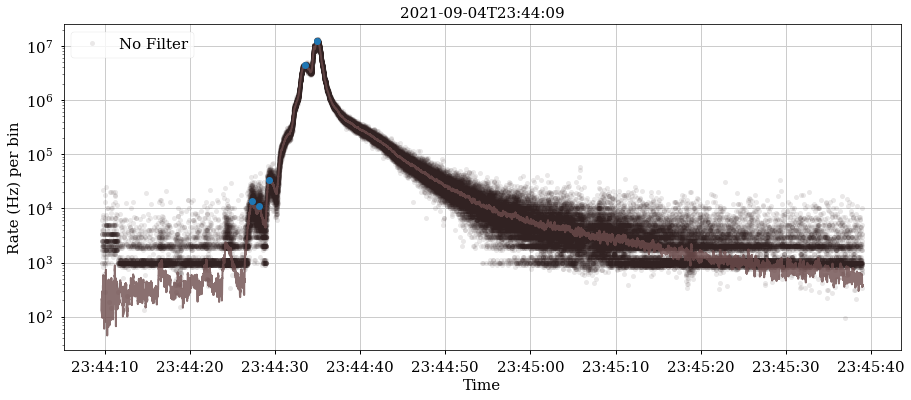

In [217]:
pmtspec, timestamp = pmt_specs[0], selected_timestamps[0]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
timemask = times_ns >= timestamp + np.timedelta64(0, "s")
timemask &= times_ns <= timestamp + np.timedelta64(90, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 6))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
    smoothed_rate = uniform_filter1d(
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]], size=filter_N
    )
    plt.plot(
        masked_times_ns,
        smoothed_rate,
        color=change_color_ld(wavelength_to_rgb(ch, gamma=0.4), +0.2),
        lw=2,
        alpha=0.8,
    )
    peaks, prop = find_peaks(
        smoothed_rate,
        height=1e4,
        width=filter_N,
        distance=filter_N,
        rel_height=0.3
        # prominence=8E3
    )
    plt.plot(
        masked_times_ns[peaks], smoothed_rate[peaks], marker="o", lw=0, color="tab:blue"
    )
plt.legend(loc=2, ncol=2)
plt.semilogy()
plt.ylabel("Rate (Hz) per bin")
plt.xlabel("Time")

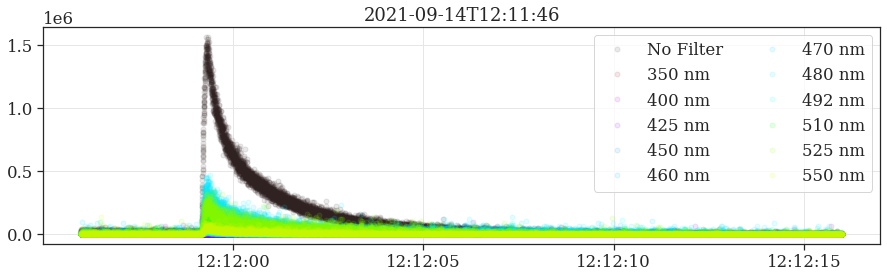

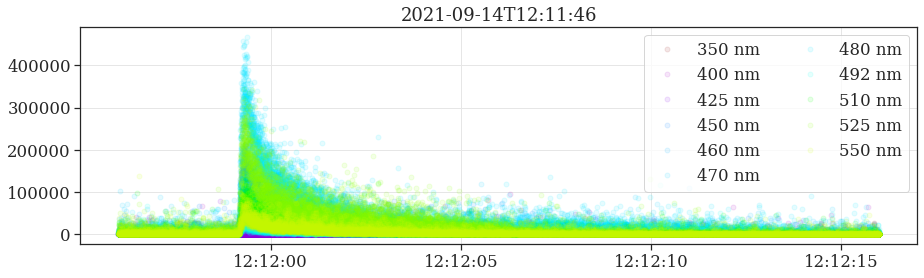

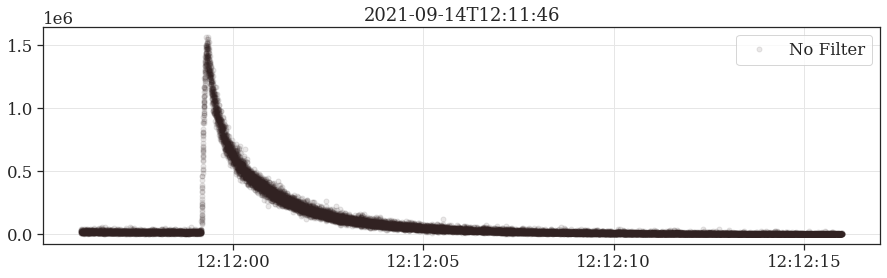

In [26]:
pmtspec, timestamp = pmt_specs[1], selected_timestamps[1]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(10, "s")
timemask &= times_ns <= timestamp + np.timedelta64(30, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


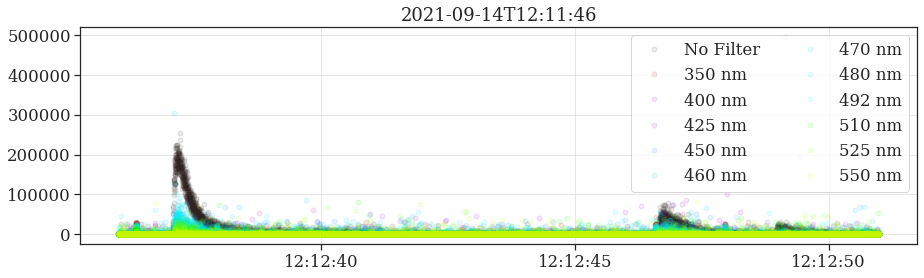

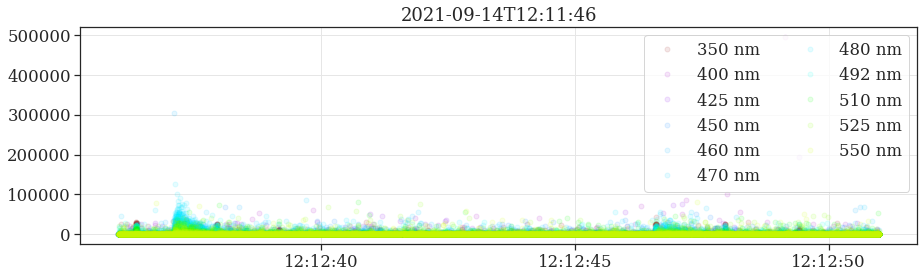

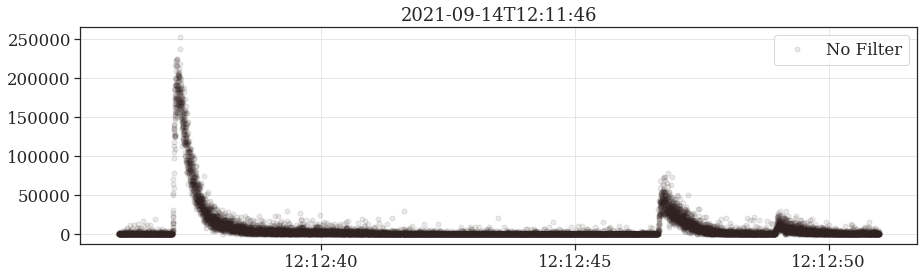

In [27]:
pmtspec, timestamp = pmt_specs[1], selected_timestamps[1]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(50, "s")
timemask &= times_ns <= timestamp + np.timedelta64(65, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


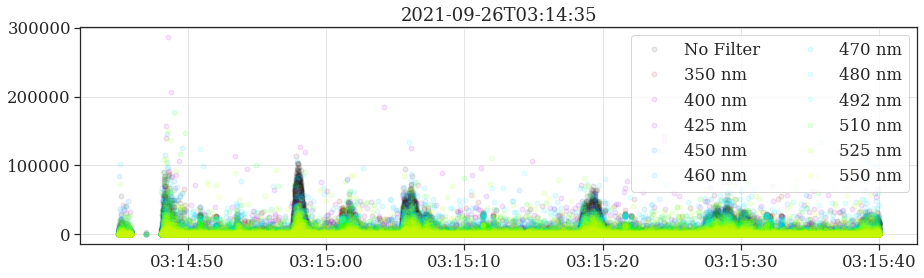

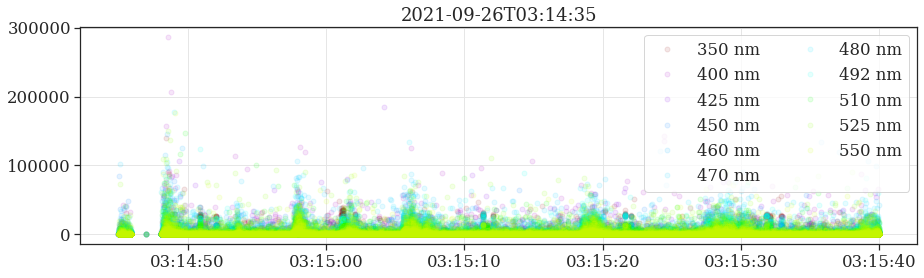

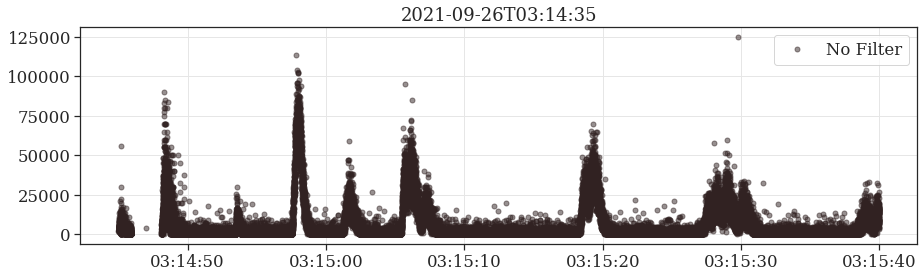

In [28]:
pmtspec, timestamp = pmt_specs[2], selected_timestamps[2]

pmtspec.pmt_meta_data.add_colors(
    plt.cm.get_cmap("viridis"), None, sns.color_palette("dark:red", as_cmap=True)
)

times_ns = strawb.tools.asdatetime(pmtspec.trb_rates.time, "ns")
### select +-2min around biolumi events
timemask = times_ns >= timestamp + np.timedelta64(10, "s")
timemask &= times_ns <= timestamp + np.timedelta64(65, "s")
masked_times_ns = times_ns[timemask]

plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] != 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.1,
        ms=5,
    )
plt.legend(loc=1, ncol=2)


plt.figure(figsize=(15, 4))
plt.title(timestamp)
for ch in pmtspec.pmt_meta_data.channel_meta_array[
    pmtspec.pmt_meta_data.channel_meta_array["wavelength"] == 0
]:
    _ = plt.plot(
        masked_times_ns,
        pmtspec.trb_rates.rate.T[timemask][:, ch["index"]],
        color=wavelength_to_rgb(ch, gamma=0.4),
        label=ch["label"],
        marker="o",
        lw=0,
        alpha=0.5,
        ms=5,
    )
plt.legend(loc=1, ncol=2)
